Cleaned dataset loaded: (117, 5)


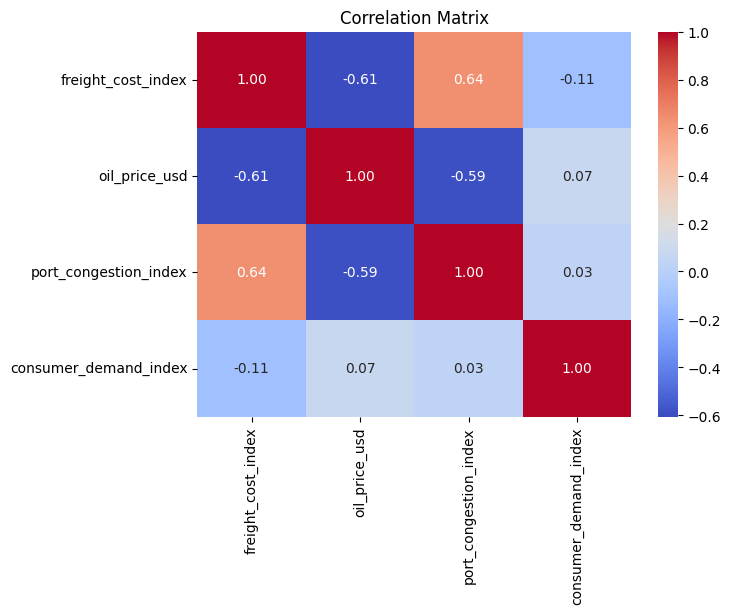

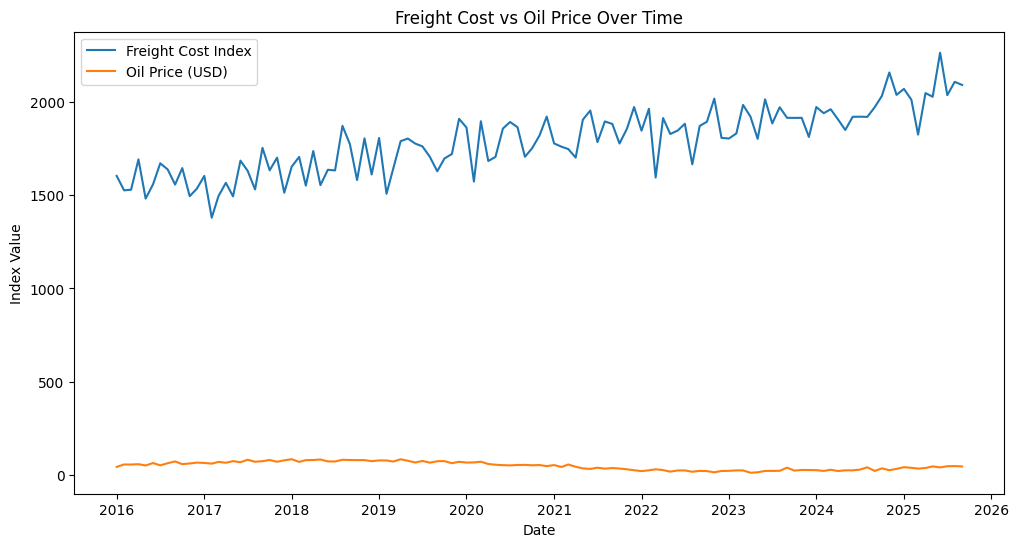

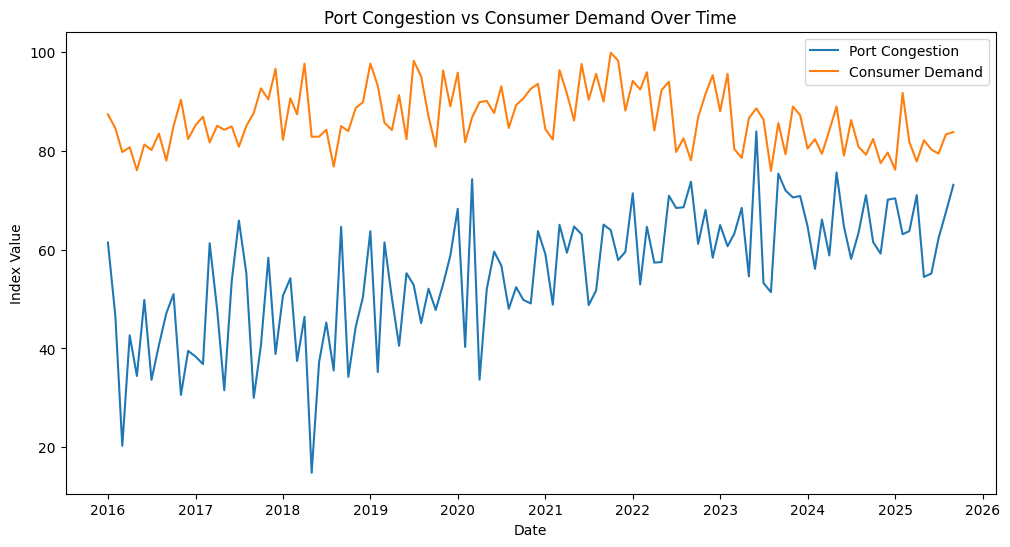

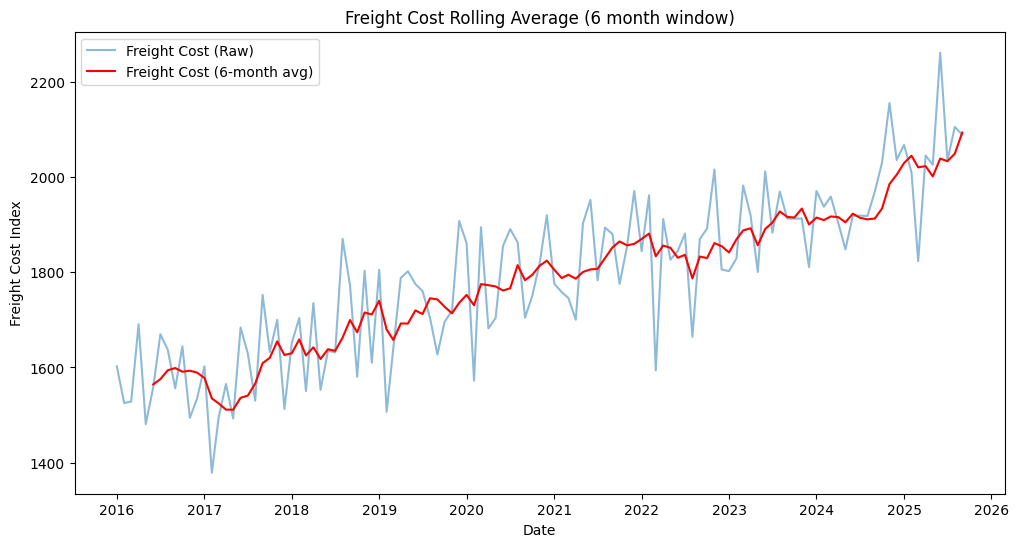

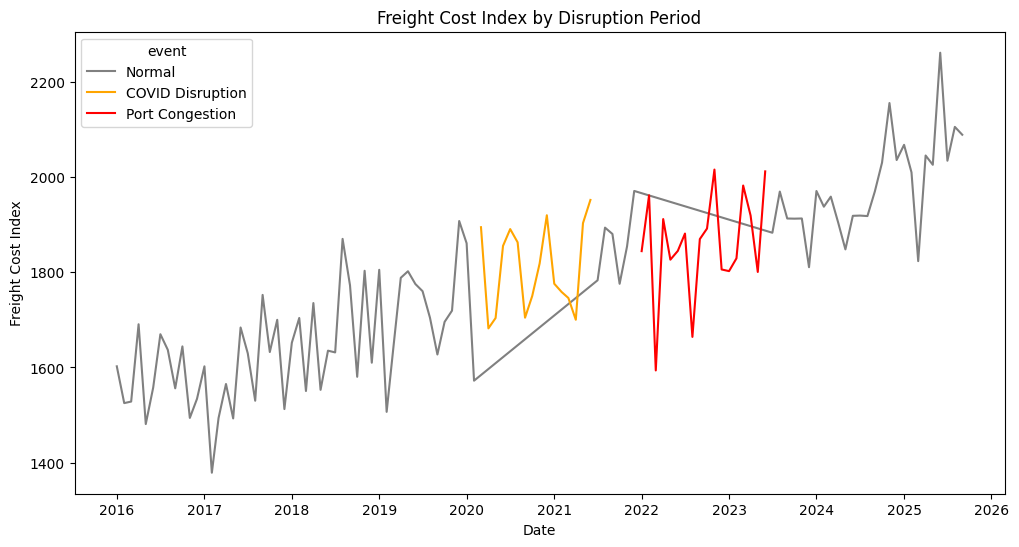

Correlation Insights
                       freight_cost_index  oil_price_usd  \
freight_cost_index               1.000000      -0.605221   
oil_price_usd                   -0.605221       1.000000   
port_congestion_index            0.639670      -0.592496   
consumer_demand_index           -0.113767       0.073352   

                       port_congestion_index  consumer_demand_index  
freight_cost_index                  0.639670              -0.113767  
oil_price_usd                      -0.592496               0.073352  
port_congestion_index               1.000000               0.030507  
consumer_demand_index               0.030507               1.000000  

Observation Highlights:
- Freight costs rise strongly with oil prices and congestion.
- Clear spikes during 2020–2023 disruption windows.
- Demand remains more stable, showing slower correlation to shipping costs.
csv saved for Tableau


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load cleaned data
cleaned_csv = "../data/processed/processed_shipping_data_clean.csv"
df = pd.read_csv(cleaned_csv)
df["date"] = pd.to_datetime(df["date"])
print("Cleaned dataset loaded:", df.shape)
df.head()

# Correlation Analysis
corr = df[["freight_cost_index", "oil_price_usd", "port_congestion_index", "consumer_demand_index"]].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Correlation Matrix")
plt.show()

# Time Series Analysis
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="freight_cost_index", label="Freight Cost Index")
sns.lineplot(data=df, x="date", y="oil_price_usd", label="Oil Price (USD)")
plt.title("Freight Cost vs Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="port_congestion_index", label="Port Congestion")
sns.lineplot(data=df, x="date", y="consumer_demand_index", label="Consumer Demand")
plt.title("Port Congestion vs Consumer Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.show()

# Rolling Averages
df["freight_cost_rolling"] = df["freight_cost_index"].rolling(window=6).mean()
df["oil_price_rolling"] = df["oil_price_usd"].rolling(window=6).mean()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="freight_cost_index", label="Freight Cost (Raw)", alpha=0.5)
sns.lineplot(data=df, x="date", y="freight_cost_rolling", label="Freight Cost (6-month avg)", color="red")
plt.title("Freight Cost Rolling Average (6 month window)")
plt.xlabel("Date")
plt.ylabel("Freight Cost Index")
plt.legend()
plt.show()

# Event Window Analysis
df["event"] = np.where(
    (df["date"].between("2020-03-01", "2021-06-01")), "COVID Disruption",
    np.where(df["date"].between("2022-01-01", "2023-06-01"), "Port Congestion", "Normal")
)

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="freight_cost_index", hue="event", palette= {"COVID Disruption" : "orange", "Port Congestion" : "red", "Normal" : "gray"})
plt.title("Freight Cost Index by Disruption Period")
plt.xlabel("Date")
plt.ylabel("Freight Cost Index")
plt.show()

# Summary Insights
print("Correlation Insights")
print(corr)

print("\nObservation Highlights:")
print("- Freight costs rise strongly with oil prices and congestion.")
print("- Clear spikes during 2020–2023 disruption windows.")
print("- Demand remains more stable, showing slower correlation to shipping costs.")

df.to_csv("../data/processed/eda_shippig_features.csv", index=False)
print("csv saved for Tableau")

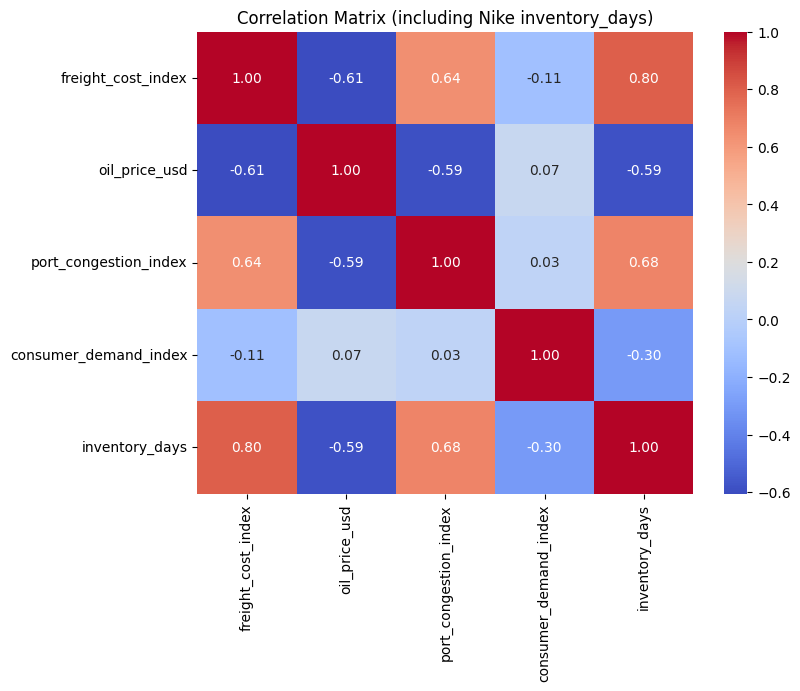


Correlation with inventory_days:
inventory_days           1.000000
freight_cost_index       0.804941
port_congestion_index    0.675774
consumer_demand_index   -0.300494
oil_price_usd           -0.585148
Name: inventory_days, dtype: float64

Linear fit: inventory_days ~ freight_cost_index (R² = 0.648)


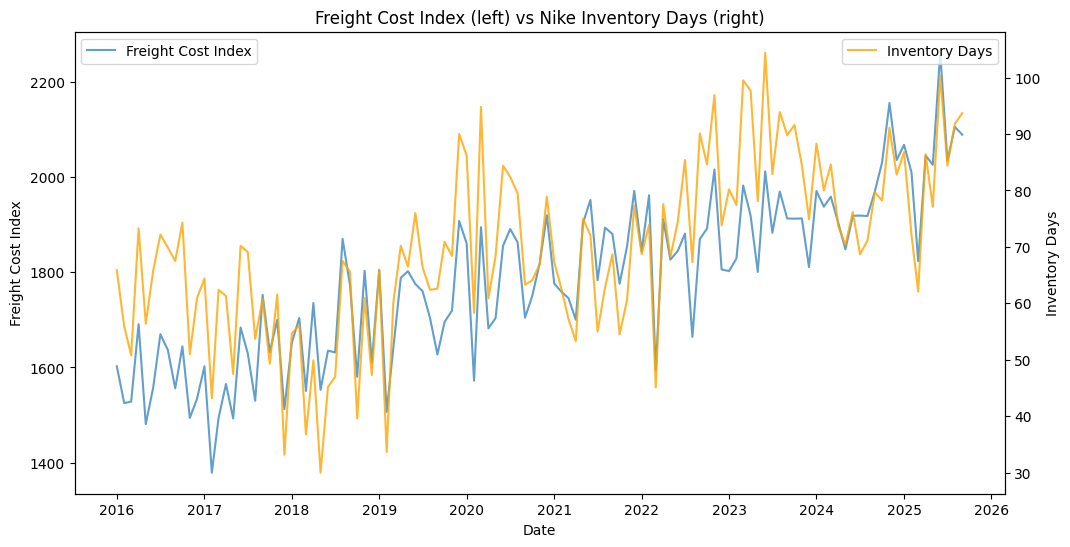

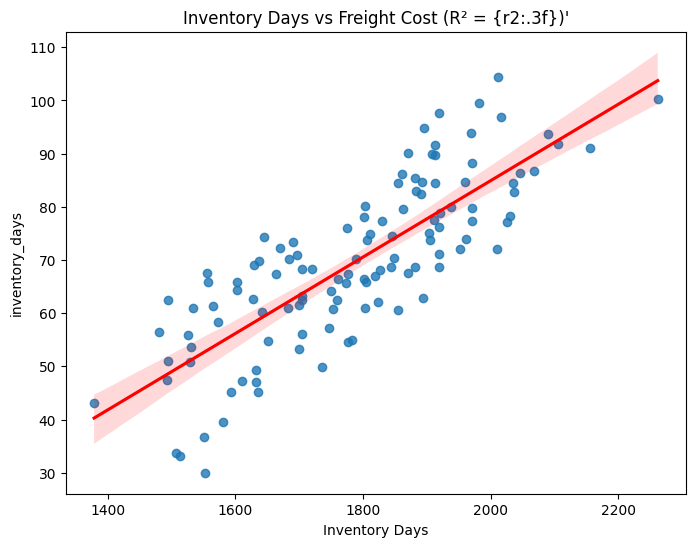


Outpath saved


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

try:
    df
except NameError:
    df = pd.read_csv("../data/processed/eda_shipping_features.csv")
    df["date"] = pd.to_datetime(df["date"])

# creating synthetic nike inventory data
np.random.seed(42)

freight_scaled = (df["freight_cost_index"] - df["freight_cost_index"].mean()) / df["freight_cost_index"].std()
cong_scaled = (df["port_congestion_index"] - df["port_congestion_index"].mean()) / df["port_congestion_index"].std()
demand_scaled = (df["consumer_demand_index"] - df["consumer_demand_index"].mean()) / df["consumer_demand_index"].std()

# base inventory days
base_inventory = 70 + 10 * np.sin(np.linspace(0, 6*np.pi, len(df)))

inventory_noise = np.random.normal(0,4,len(df))
df["inventory_days"] = (base_inventory
                       + 8 * freight_scaled
                       + 6 * cong_scaled
                       - 3 * demand_scaled
                       + inventory_noise).round(1)

df["inventory_days"] = df["inventory_days"].clip(lower=30, upper=180)

cols = ["freight_cost_index", "oil_price_usd", "port_congestion_index", "consumer_demand_index", "inventory_days"]
corr = df[cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Correlation Matrix (including Nike inventory_days)")
plt.show()

print("\nCorrelation with inventory_days:")
print(corr["inventory_days"].sort_values(ascending=False))

# Time-series overlay : freight cost and inventory days
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df["date"], df["freight_cost_index"], label="Freight Cost Index", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("Freight Cost Index")
ax2 = ax1.twinx()
ax2.plot(df["date"], df["inventory_days"], color="orange", label="Inventory Days", alpha=0.8)
ax2.set_ylabel("Inventory Days")
ax1.set_title("Freight Cost Index (left) vs Nike Inventory Days (right)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show

X = df[["freight_cost_index"]].values.reshape(-1,1)
y = df["inventory_days"].values
model = LinearRegression().fit(X,y)
y_pred = model.predict(X)
r2 = r2_score(y,y_pred)
print(f"\nLinear fit: inventory_days ~ freight_cost_index (R² = {r2:.3f})")

plt.figure(figsize=(8,6))
sns.regplot(x="freight_cost_index", y="inventory_days", data=df, line_kws={"color" : "red"})
plt.title("Inventory Days vs Freight Cost (R² = {r2:.3f})'")
plt.xlabel("Inventory Days")
plt.show()

out_path = "../data/processed/eda_shipping_features_with_nike.csv"
df.to_csv(out_path, index=False)
print(f"\nOutpath saved")
